# DSI Tutorial and getting started

The goal of the Data Science Infrastructure Project ([DSI](https://github.com/lanl/dsi)) is to provide a flexible, AI-ready metadata query capability which returns data subject to strict, POSIX-enforced file security. In this tutorial, you will learn how to:
 - initialize a DSI instance
 - load data into DSI
 - check the data loaded
 - query the data
 - create new data and save it to DSI
 - load complex schemas
 - use DSI writers

This tutorial uses data from the [Cloverleaf3D](https://github.com/UK-MAC/CloverLeaf3D) Lagrangian-Eulerian hydrodynamics solver. Archived data is provided in dsi/examples/clover3d. Prior to running the tutorial, extract clover3d.zip and please follow the instructions in the [Quick Start: Installation](https://lanl.github.io/dsi/installation.html) to set up DSI.



In [1]:
from dsi.dsi import DSI

In [2]:
# Create instance of DSI
baseline = DSI()

Created an instance of DSI


# Available features

To see which available backends, readers and writers area available, you can try calling funtionst to list the featureset available in your instalation.

In [3]:
# Lists available backends
baseline.list_backends()


Valid Backends for `backend_name` in backend():
----------------------------------------
Sqlite : Lightweight, file-based SQL backend. Default backend used by DSI API.
DuckDB : In-process SQL backend optimized for fast analytics on large datasets.




In [4]:
# Lists available readers
baseline.list_readers()


Valid Readers for `reader_name` in read():
--------------------------------------------------
CSV                  : Loads data from CSV files (one table per call)
YAML1                : Loads data from YAML files of a certain structure
TOML1                : Loads data from TOML files of a certain structure
JSON                 : Loads single-table data from JSON files
Ensemble             : Loads a CSV file where each row is a simulation run; creates a simulation table
Cloverleaf           : Loads data from a directory with subfolders for each simulation run's input and output data
Bueno                : Loads performance data from Bueno (github.com/lanl/bueno) (.data text file format)
DublinCoreDatacard   : Loads dataset metadata adhering to the Dublin Core format (XML)
SchemaOrgDatacard    : Loads dataset metadata adhering to schema.org (JSON)
GoogleDatacard       : Loads dataset metadata adhering to the Google Data Cards Playbook (YAML)
Oceans11Datacard     : Loads dataset metada

In [5]:
# Lists available writers
baseline.list_writers()


Valid Writers for `writer_name` in write(): ['ER_Diagram', 'Table_Plot', 'Csv_Writer'] 

ER_Diagram  : Creates a visual ER diagram image based on all tables in DSI.
Table_Plot  : Generates a plot of numerical data from a specified table.
Csv_Writer  : Exports the data of a specified table to a CSV file.



# Reading Data into DSI

For this tutorial, we will use cloverleaf 3d data available in our repository. dsi/examples/clover3d/clover3d.zip
Alternitively, you can download the data from this direct link: https://github.com/lanl/dsi/raw/refs/heads/main/examples/clover3d/clover3d.zip

* Use a unix terminal / windows powershell to pull the data and extract locally into ./clover3d folder

The data is an ensemble of 8 runs, and has 4 metadata products of interest:

* clover.in - input deck
* clover.out - simulation statistics
* timestamps.txt - time when simulation was launched on slurm
* viz files - insitu outputs in vtk format

To begin the ingest:

In [6]:
# Target backend defaults to SQLite since not defined
store = DSI("dsi-tutorial.db")

# dsi.read(filename, reader)
store.read("./clover3d/", 'Cloverleaf')

Created an instance of DSI with the Sqlite backend: dsi-tutorial.db
Loaded ./clover3d/ into tables: input, output, simulation, viz_files


# Exploring the loaded data

In [7]:
# How many tables do we have
store.num_tables()

Database now has 4 tables


In [8]:
# Let's see what tables were created
store.list()


Table: input
  - num of columns: 22
  - num of rows: 8

Table: output
  - num of columns: 10
  - num of rows: 720

Table: simulation
  - num of columns: 2
  - num of rows: 8

Table: viz_files
  - num of columns: 2
  - num of rows: 80




In [9]:
# Let's get more details about the data
store.summary()


Table: input

column           | type    | min  | max  | avg                 | std_dev               
---------------------------------------------------------------------------------------
sim_id           | INTEGER | 1    | 8    | 4.5                 | 2.29128784747792      
state1_density   | FLOAT   | 0.2  | 0.2  | 0.19999999999999998 | 2.7755575615628914e-17
state1_energy    | FLOAT   | 1.0  | 1.0  | 1.0                 | 0.0                   
state2_density   | FLOAT   | 2.0  | 9.0  | 5.5                 | 2.29128784747792      
state2_energy    | FLOAT   | 2.5  | 2.5  | 2.5                 | 0.0                   
state2_geometry  | VARCHAR | None | None | None                | None                  
state2_xmin      | FLOAT   | 0.0  | 0.0  | 0.0                 | 0.0                   
state2_xmax      | FLOAT   | 5.0  | 5.0  | 5.0                 | 0.0                   
state2_ymin      | FLOAT   | 0.0  | 0.0  | 0.0                 | 0.0                   
state2_ymax      

In [10]:
# Preview the contents of the visualization files
store.display("viz_files")


Table: viz_files

sim_id | image_filepath                    
-------------------------------------------
1      | run_1/clover.00000.00001.00000.vtk
1      | run_1/clover.00000.00001.00010.vtk
1      | run_1/clover.00000.00001.00020.vtk
1      | run_1/clover.00000.00001.00030.vtk
1      | run_1/clover.00000.00001.00040.vtk
1      | run_1/clover.00000.00001.00050.vtk
1      | run_1/clover.00000.00001.00060.vtk
1      | run_1/clover.00000.00001.00070.vtk
1      | run_1/clover.00000.00001.00080.vtk
1      | run_1/clover.00000.00001.00090.vtk
2      | run_2/clover.00000.00001.00000.vtk
2      | run_2/clover.00000.00001.00010.vtk
2      | run_2/clover.00000.00001.00020.vtk
2      | run_2/clover.00000.00001.00030.vtk
2      | run_2/clover.00000.00001.00040.vtk
2      | run_2/clover.00000.00001.00050.vtk
2      | run_2/clover.00000.00001.00060.vtk
2      | run_2/clover.00000.00001.00070.vtk
2      | run_2/clover.00000.00001.00080.vtk
2      | run_2/clover.00000.00001.00090.vtk
3      | run_

# DSI Find to search within the data

In [11]:
# Search string or value within all tables
store.find("Jun 2025")

Finding all instances of 'Jun 2025' in the active backend

Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row Number: 1
  - Data: [1, 'Thu 05 Jun 2025 01:25:34 PM MDT']
Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row Number: 2
  - Data: [2, 'Thu 05 Jun 2025 01:25:34 PM MDT']
Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row Number: 3
  - Data: [3, 'Thu 05 Jun 2025 01:25:34 PM MDT']
Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row Number: 4
  - Data: [4, 'Thu 05 Jun 2025 01:25:34 PM MDT']
Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row Number: 5
  - Data: [5, 'Thu 05 Jun 2025 01:25:34 PM MDT']
Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row Number: 6
  - Data: [6, 'Thu 05 Jun 2025 01:25:34 PM MDT']
Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row Number: 7
  - Data: [7, 'Thu 05 Jun 2025 01:25:34 PM MDT']
Table: simulation
  - Columns: ['sim_id', 'sim_datetime']
  - Row 

In [12]:
# Perform a search and receive a collection
find_list = store.find("8.0", True) # Use True to return a collection

Finding all instances of '8.0' in the active backend
Note: Output includes 2 'dsi_' columns required for dsi.update(). DO NOT modify if updating; keep any extra rows blank. Drop if not updating.



In [13]:
# Simply display what this collection (pandas dataframe) looks like
find_list

,dsi_table_name,dsi_row_index,sim_id,state1_density,state1_energy,state2_density,state2_energy,state2_geometry,state2_xmin,state2_xmax,...,xmin,ymin,xmax,ymax,initial_timestep,timestep_rise,max_timestep,end_step,test_problem,visit_frequency
0,input,7,7,0.2,1.0,8.0,2.5,rectangle,0.0,5.0,...,0.0,0.0,10.0,10.0,0.04,1.5,0.04,90,2,10


In [14]:
find_list = store.find("time>3.0", True)

Finding all rows where 'time>3.0' in the active backend
Note: Output includes 2 'dsi_' columns required for dsi.update(). DO NOT modify if updating; keep any extra rows blank. Drop if not updating.



In [15]:
find_list

,dsi_table_name,dsi_row_index,sim_id,step,time,control,timestep,x,y,wall_clock,average_time_per_cell,step_time_per_cell
0,output,77,1,77,3.04,sound,0.04,0.0833,0.0833,0.093779,3.383084e-07,7.417467e-08
1,output,78,1,78,3.08,sound,0.04,0.0833,0.0833,0.094051,3.349399e-07,7.390976e-08
2,output,79,1,79,3.12,sound,0.04,0.0833,0.0833,0.094324,3.316600e-07,7.417467e-08
3,output,80,1,80,3.16,sound,0.04,0.0833,0.0833,0.105250,3.654518e-07,3.033082e-06
4,output,81,1,81,3.20,sound,0.04,0.0833,0.0833,0.105528,3.618934e-07,7.503563e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
107,output,716,8,86,3.40,sound,0.04,0.0833,0.0833,0.107807,3.482136e-07,7.530053e-08
108,output,717,8,87,3.44,sound,0.04,0.0833,0.0833,0.108086,3.451018e-07,7.556544e-08
109,output,718,8,88,3.48,sound,0.04,0.0833,0.0833,0.108364,3.420577e-07,7.523431e-08
110,output,719,8,89,3.52,sound,0.04,0.0833,0.0833,0.108643,3.390857e-07,7.556544e-08


# Updating contents with DSI

DSI Allows you to add or modify existing contents inside a collection that was returned from
a find or a query operation when 'True' is used.

Example usecase: We want to perform post-processing of the ingested data. In this example, we would like to append additional information to our DSI Database. We want to convert the simulation date from text to numerical unix time.

In [16]:
find_list = store.find("Jun 2025", True)

Finding all instances of 'Jun 2025' in the active backend
Note: Output includes 2 'dsi_' columns required for dsi.update(). DO NOT modify if updating; keep any extra rows blank. Drop if not updating.



In [17]:
find_list

,dsi_table_name,dsi_row_index,sim_id,sim_datetime
0,simulation,1,1,Thu 05 Jun 2025 01:25:34 PM MDT
1,simulation,2,2,Thu 05 Jun 2025 01:25:34 PM MDT
2,simulation,3,3,Thu 05 Jun 2025 01:25:34 PM MDT
3,simulation,4,4,Thu 05 Jun 2025 01:25:34 PM MDT
4,simulation,5,5,Thu 05 Jun 2025 01:25:34 PM MDT
5,simulation,6,6,Thu 05 Jun 2025 01:25:34 PM MDT
6,simulation,7,7,Thu 05 Jun 2025 01:25:34 PM MDT
7,simulation,8,8,Thu 05 Jun 2025 01:25:35 PM MDT


In [18]:
# Small amount of helper code to convert dates to unix time
from datetime import datetime
from zoneinfo import ZoneInfo
def str2unix(date_str):
    date_str_clean = date_str.rsplit(' ', 1)[0]  # remove 'MDT'
    dt_naive = datetime.strptime(date_str_clean, "%a %d %b %Y %I:%M:%S %p")
    # Set timezone
    dt_local = dt_naive.replace(tzinfo=ZoneInfo("America/Denver"))
    unix_time = int(dt_local.timestamp()) # Unix time in UTC
    return unix_time

In [19]:
store.display("simulation") # display table before update


Table: simulation

sim_id | sim_datetime                   
----------------------------------------
1      | Thu 05 Jun 2025 01:25:34 PM MDT
2      | Thu 05 Jun 2025 01:25:34 PM MDT
3      | Thu 05 Jun 2025 01:25:34 PM MDT
4      | Thu 05 Jun 2025 01:25:34 PM MDT
5      | Thu 05 Jun 2025 01:25:34 PM MDT
6      | Thu 05 Jun 2025 01:25:34 PM MDT
7      | Thu 05 Jun 2025 01:25:34 PM MDT
8      | Thu 05 Jun 2025 01:25:35 PM MDT



In [21]:
print(find_list)

  dsi_table_name  dsi_row_index  sim_id                     sim_datetime
0     simulation              1       1  Thu 05 Jun 2025 01:25:34 PM MDT
1     simulation              2       2  Thu 05 Jun 2025 01:25:34 PM MDT
2     simulation              3       3  Thu 05 Jun 2025 01:25:34 PM MDT
3     simulation              4       4  Thu 05 Jun 2025 01:25:34 PM MDT
4     simulation              5       5  Thu 05 Jun 2025 01:25:34 PM MDT
5     simulation              6       6  Thu 05 Jun 2025 01:25:34 PM MDT
6     simulation              7       7  Thu 05 Jun 2025 01:25:34 PM MDT
7     simulation              8       8  Thu 05 Jun 2025 01:25:35 PM MDT


In [27]:
# Iterate through collection and append new metadata
find_list["sim_unixtime"] = find_list["sim_datetime"].apply(str2unix)

#dsi.update(collection)
store.update(find_list) # update all tables in the list
#store.update(find_list[0]) # Optionally, update only first table in the list


Updating the active backend with the input collection of data


In [28]:
# See the updated results
store.display("simulation")


Table: simulation

sim_id | sim_datetime                    | sim_unixtime
-------------------------------------------------------
1      | Thu 05 Jun 2025 01:25:34 PM MDT | 1749151534  
2      | Thu 05 Jun 2025 01:25:34 PM MDT | 1749151534  
3      | Thu 05 Jun 2025 01:25:34 PM MDT | 1749151534  
4      | Thu 05 Jun 2025 01:25:34 PM MDT | 1749151534  
5      | Thu 05 Jun 2025 01:25:34 PM MDT | 1749151534  
6      | Thu 05 Jun 2025 01:25:34 PM MDT | 1749151534  
7      | Thu 05 Jun 2025 01:25:34 PM MDT | 1749151534  
8      | Thu 05 Jun 2025 01:25:35 PM MDT | 1749151535  



# Query DSI

DSI Supports direct SQL queries to the data that you have ingested

In [29]:
# Use sql statement to directly query the backend store
store.query("SELECT sim_id, xmin, ymin, xmax, ymax, state2_density FROM input") # Adding 'True' gives a collection

Printing the result of the SQL query: SELECT sim_id, xmin, ymin, xmax, ymax, state2_density FROM input

sim_id | xmin | ymin | xmax | ymax | state2_density
---------------------------------------------------
1.0    | 0.0  | 0.0  | 10.0 | 10.0 | 2.0           
2.0    | 0.0  | 0.0  | 10.0 | 10.0 | 3.0           
3.0    | 0.0  | 0.0  | 10.0 | 10.0 | 4.0           
4.0    | 0.0  | 0.0  | 10.0 | 10.0 | 5.0           
5.0    | 0.0  | 0.0  | 10.0 | 10.0 | 6.0           
6.0    | 0.0  | 0.0  | 10.0 | 10.0 | 7.0           
7.0    | 0.0  | 0.0  | 10.0 | 10.0 | 8.0           
8.0    | 0.0  | 0.0  | 10.0 | 10.0 | 9.0           



In [30]:
# alternative to "query()" if you want to get a whole table
store.get_table("input") # Adding 'True' gives a collection

Printing all data from the table: input

sim_id | state1_density | state1_energy | state2_density | state2_energy | state2_geometry | state2_xmin | state2_xmax | state2_ymin | state2_ymax | x_cells | y_cells | xmin | ymin | xmax | ymax | initial_timestep | timestep_rise | max_timestep | end_step | test_problem | visit_frequency
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      | 0.2            | 1.0           | 2.0            | 2.5           | rectangle       | 0.0         | 5.0         | 0.0         | 2.0         | 60      | 60      | 0.0  | 0.0  | 10.0 | 10.0 | 0.04             | 1.5           | 0.04         | 90       | 2            | 10             
2      | 0.2            | 1.0           | 3.0            | 2.5           | rectangle       |

# DSI Write - Complex Schemas

DSI has support to represent complex schemas. For example, if you would like to relate the different tables together you can use the schema reader which takes in a .json file.

* schema.json

Before defining and ingesting a complmex schema, what does an Entity Relationship Diagram look like in our initial schema?

Successfully wrote to the output file clover_er_diagram_no_schema.png


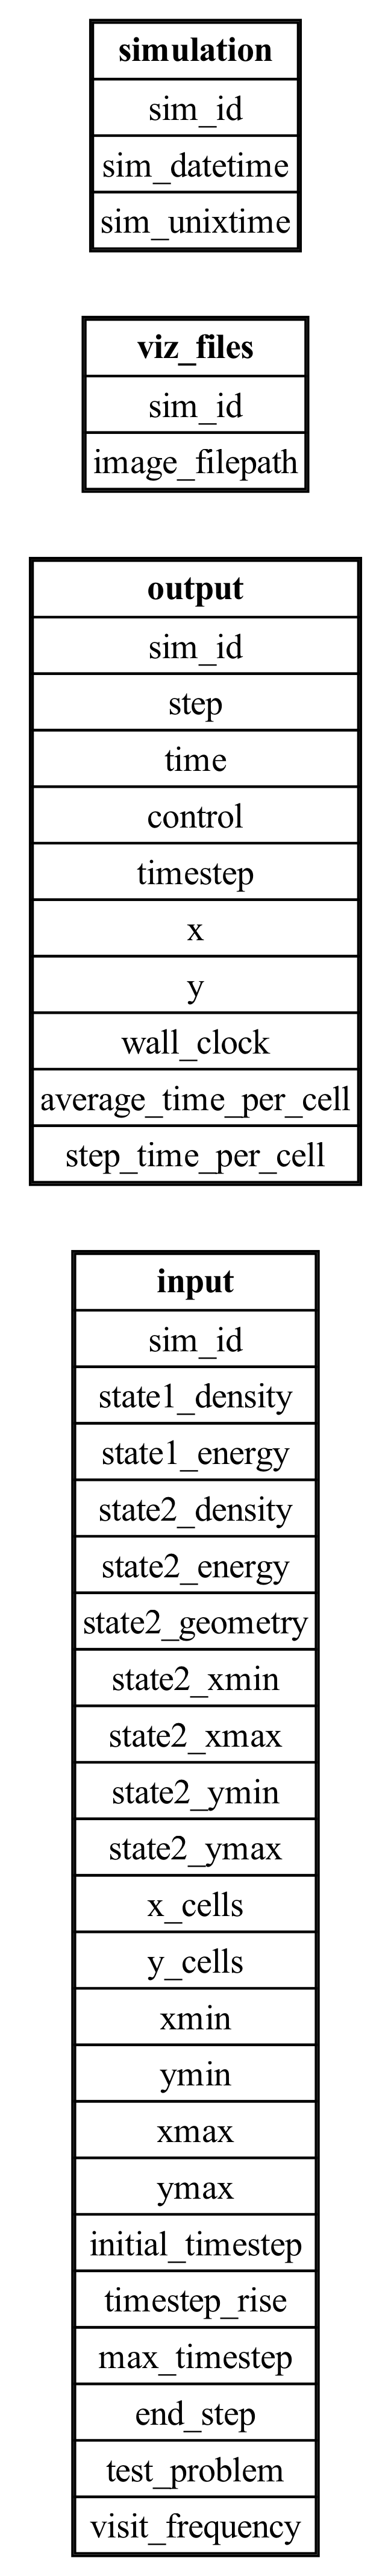

In [31]:
store.write("clover_er_diagram_no_schema.png", "ER_Diagram")

from IPython.display import Image
Image(filename="clover_er_diagram_no_schema.png", width=200)

In [32]:
# Create a new database where we will relate a complex schema
schema_store = DSI("schema_tutorial.db")

# dsi.schema(filename)
schema_store.schema("./clover3d/schema.json") # Schema neeeds to be defined before reading Cloverleaf data

# dsi.read(filename, reader)
schema_store.read("./clover3d/", 'Cloverleaf') # read in Cloverleaf data

# dsi.write(filename, writer)
schema_store.write("clover_er_diagram.png", "ER_Diagram")

Created an instance of DSI with the Sqlite backend: schema_tutorial.db
Successfully loaded the schema file: ./clover3d/schema.json
Loaded ./clover3d/ into tables: input, output, simulation, viz_files
Successfully wrote to the output file clover_er_diagram.png


To preview the Entity Realationship Diagram (ERDiagram), import libraries to display images

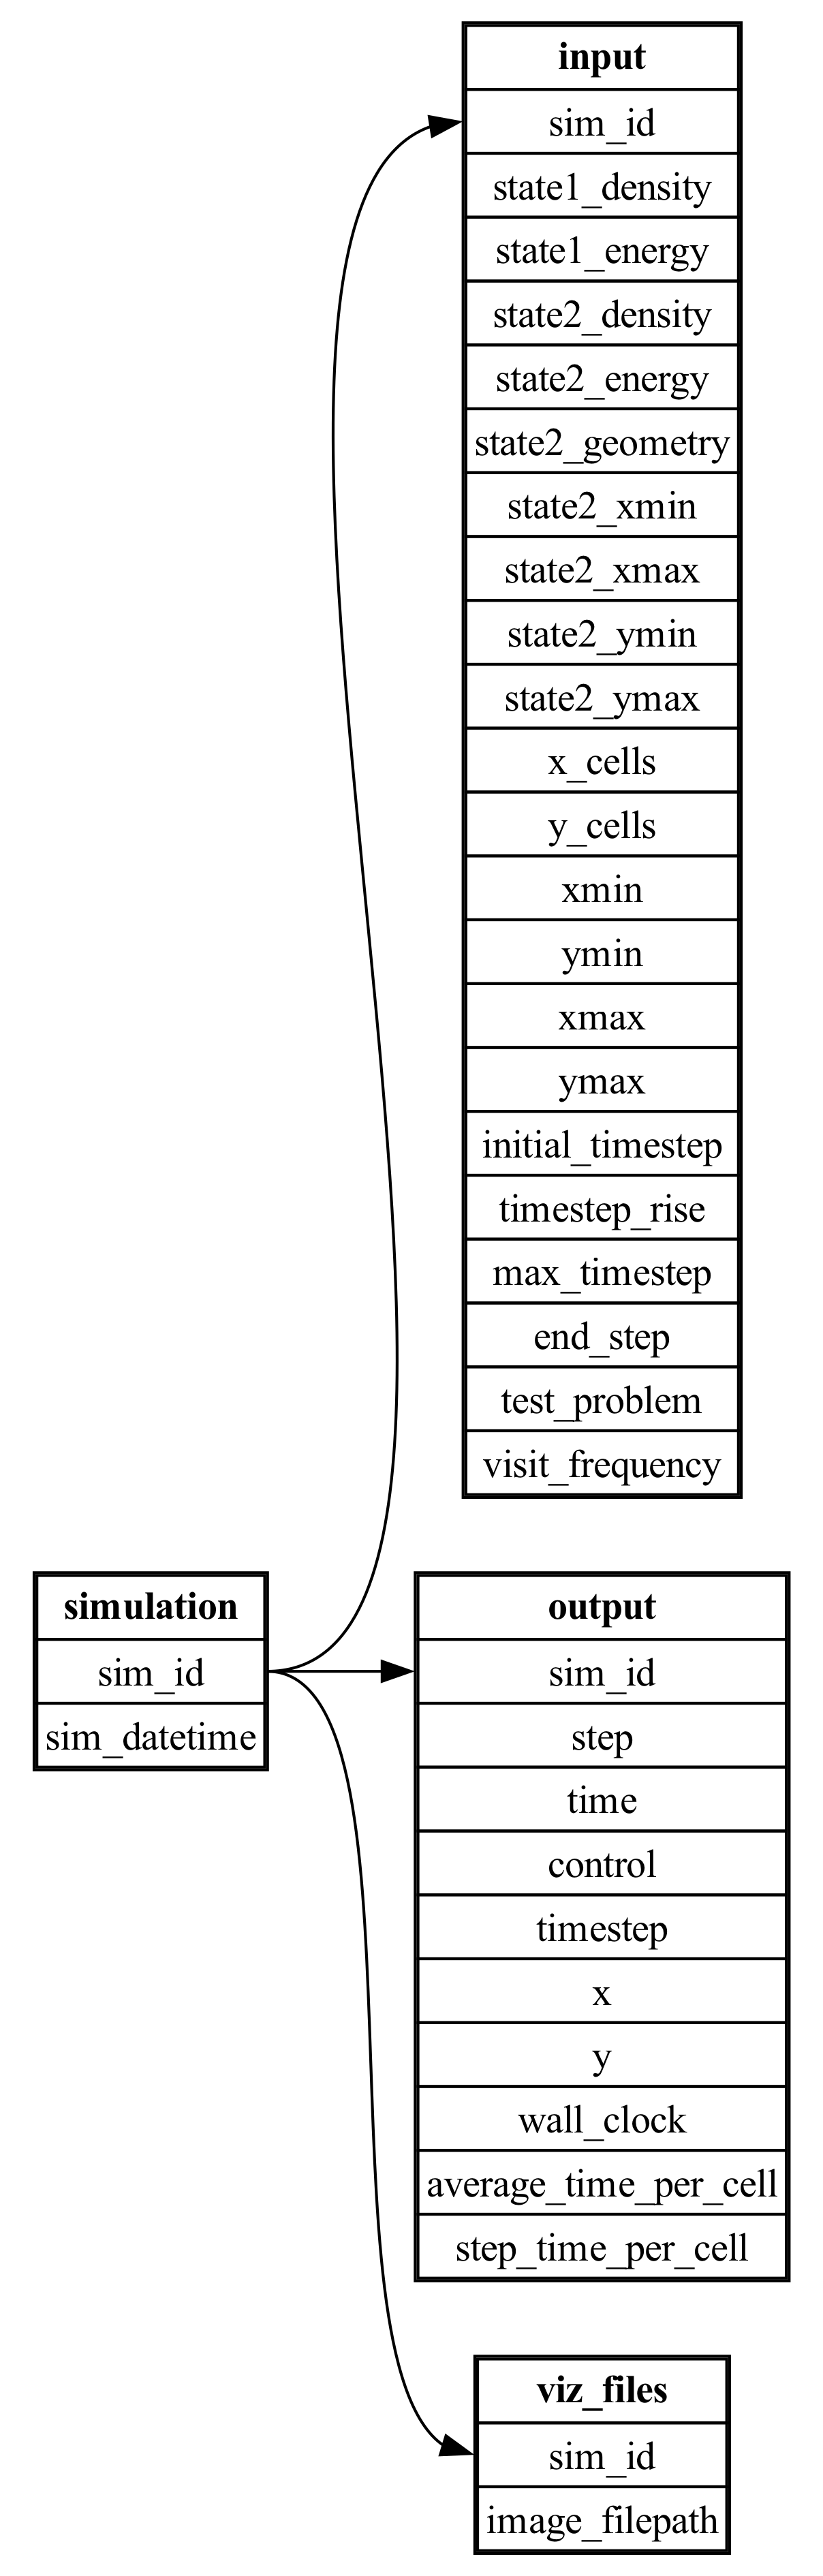

In [33]:
from IPython.display import Image
Image(filename="clover_er_diagram.png", width=300)

# DSI Write - CSV

DSI Support the output (write) of data if you would like to export into another project.

In [34]:
store.write("input.csv", "Csv_Writer", "input")

Successfully wrote to the output file input.csv


# DSI Write - Table plot
DSI has a built in tool to assist in plotting tables

In [35]:
store.write("output_table_plot.png", "Table_Plot", "output")

Successfully wrote to the output file output_table_plot.png


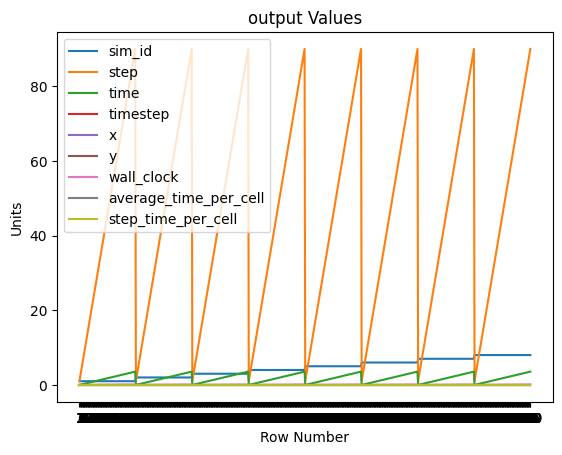

In [36]:
Image(filename="output_table_plot.png", width=400)

# Ending your workflow

In [37]:
store.close()
schema_store.close()

Closing this instance of DSI()
Closing this instance of DSI()


# Reloading your workflow

In [38]:
# Target backend defaults to SQLite since not defined
store = DSI("dsi-tutorial.db")
store.summary()

Created an instance of DSI with the Sqlite backend: dsi-tutorial.db

Table: input

column           | type    | min  | max  | avg                 | std_dev               
---------------------------------------------------------------------------------------
sim_id           | INTEGER | 1    | 8    | 4.5                 | 2.29128784747792      
state1_density   | FLOAT   | 0.2  | 0.2  | 0.19999999999999998 | 2.7755575615628914e-17
state1_energy    | FLOAT   | 1.0  | 1.0  | 1.0                 | 0.0                   
state2_density   | FLOAT   | 2.0  | 9.0  | 5.5                 | 2.29128784747792      
state2_energy    | FLOAT   | 2.5  | 2.5  | 2.5                 | 0.0                   
state2_geometry  | VARCHAR | None | None | None                | None                  
state2_xmin      | FLOAT   | 0.0  | 0.0  | 0.0                 | 0.0                   
state2_xmax      | FLOAT   | 5.0  | 5.0  | 5.0                 | 0.0                   
state2_ymin      | FLOAT   | 0.0  | 0

# Moving your data with DSI

In [39]:
from dsi.core import Sync

In [40]:
#Origin
local_files = "/Users/Shared/dev/dsi/examples/clover3d/"
#Remote
remote_path = "/Users/Shared/staging/"

In [41]:
# Create Sync type with project name
s = Sync("dsi-tutorial.db")

In [42]:
s.index(local_files,remote_path,True)

loc: /Users/Shared/dev/dsi/examples/clover3d/ rem: /Users/Shared/staging/
The directory '/Users/Shared/staging/dsi-tutorial.db' has been created remotely.
db:  /Users/Shared/dev/dsi/examples/clover3d//dsi-tutorial.db.db
Creating new fs table
Csv plugin reader loaded successfully.


NotImplementedError: Need to load a valid backend before performing an action on it